Word2Vec Model
* CBOW: Give a series of words (context) and output a word
* Skip-Gram: Give a word and output its context words (probabilities)

In [1]:
import tensorflow as tf
print("Tensorflow version: {}".format(tf.__version__))

import numpy as np
print("Numpy version: {}".format(np.__version__))

from sklearn.manifold import TSNE
import input_word_data as data

Tensorflow version: 1.9.0
Numpy version: 1.14.5
Found and verified text8.zip
Data size 17005207
Most common words (+UNK) [['UNK', 1737307], ('the', 1061396), ('of', 593677), ('and', 416629), ('one', 411764)]
Sample data [5243, 3082, 12, 6, 195, 2, 3137, 46, 59, 156] ['anarchism', 'originated', 'as', 'a', 'term', 'of', 'abuse', 'first', 'used', 'against']
3082 originated -> 5243 anarchism
3082 originated -> 12 as
12 as -> 6 a
12 as -> 3082 originated
6 a -> 195 term
6 a -> 12 as
195 term -> 2 of
195 term -> 6 a


In [2]:
print(data.vocabulary_size)
print(data.data_size)

10000
17005207


# Skip-Gram

## Hyperparameters

In [3]:
full_training = False
learning_rate = 1e-1
batch_size = 32
epochs = 5 if full_training else 1
embedding_size = 128     # Dimension of embedding vectors
num_skips = 4            # How many times to reuse target to generate a label for context.
skip_window = 5          # Window size for context to the left and right of target
neg_size = 64            # Number of negative samples to use for NCE
display = 50000 if full_training else 10000
batch_per_epoch = int(data.data_size*num_skips / batch_size)
print("batch_per_epoch: {}".format(batch_per_epoch))

batch_per_epoch: 2125650


In [4]:
val_step = 50000         # Frequency with which to perform validation
val_size = 10
val_dist_span = 500
val_examples = np.random.choice(val_dist_span, val_size, replace=False)
top_match = 8
plot_num = 500

break_flag = -1 if full_training else 60000   # stop training

## Network

In [5]:
def embedding_layer(x, embedding_shape):
    with tf.variable_scope("embedding"):
        embedding_init = tf.random_uniform(embedding_shape, -1., 1.)
        embedding_matrix = tf.get_variable("E", initializer=embedding_init)
        return tf.nn.embedding_lookup(embedding_matrix, x), embedding_matrix

## Target

In [6]:
def nosie_contrastive_loss(embedding_lookup, weight_shape, bias_shape, y):
    with tf.variable_scope("nce"):
        nce_weight_init = tf.truncated_normal(weight_shape, stddev=1.0/(weight_shape[1])**0.5)
        nce_bias_init = tf.zeros(bias_shape)
        
        nce_W = tf.get_variable("W", initializer=nce_weight_init)
        nce_b = tf.get_variable("b", initializer=nce_bias_init)
        
        """
        nce_W: weights, [num_classes, dim]
        nce_b: biases, [num_classes]
        y: labels, [batch_size, num_true], target classes
        embedding_lookup: inputs, [batch_size, dim], The forward activations of the input network.
        num_sampled: The number of negative classes to randomly sample per batch.
        num_classes: The number of possible classes.
        """
        total_loss = tf.nn.nce_loss(weights=nce_W, \
                                    biases=nce_b, \
                                    labels=y, \
                                    inputs=embedding_lookup, \
                                    num_sampled=neg_size, \
                                    num_classes=data.vocabulary_size)
        return tf.reduce_mean(total_loss)

In [7]:
def train(cost, global_step):
    with tf.variable_scope("training"):
        summary_op = tf.summary.scalar("cost", cost)
        optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
        train_op = optimizer.minimize(cost, global_step=global_step)
        return train_op, summary_op

$$y_i=\frac{x_i}{\sqrt{\sum_{j=1}^{N}{x_j^2}}}$$

In [8]:
def validation(embedding_matrix, x_val):
    norm = tf.reduce_sum(embedding_matrix**2, 1, keepdims=True)**0.5   # normalization method
    normalized = embedding_matrix / norm
    val_embeddings = tf.nn.embedding_lookup(normalized, x_val)
    similarity = tf.matmul(val_embeddings, normalized, transpose_b=True)
    return normalized, similarity

## Training

In [9]:
def startTraining():
    with tf.Graph().as_default():
        with tf.variable_scope("skipgram"):
            
            x = tf.placeholder(tf.int32, shape=[batch_size])
            y = tf.placeholder(tf.int32, [batch_size, 1])
            val = tf.constant(val_examples, tf.int32)
            global_step = tf.Variable(0, name="global_step", trainable=False)
            
            e_lookup, e_matrix = embedding_layer(x, [data.vocabulary_size, embedding_size])
            cost = nosie_contrastive_loss(e_lookup, [data.vocabulary_size, embedding_size], [data.vocabulary_size], tf.cast(y, tf.float32))
            train_op, summary_op = train(cost, global_step=global_step)
            val_op = validation(e_matrix, val)
            
            init_op = tf.global_variables_initializer()
            
            with tf.Session() as sess:
                summary_writer = tf.summary.FileWriter("/tmp/skipgram_logs/",graph=sess.graph)
                sess.run(init_op)
                
                step = 0
                
                for epoch in range(epochs):
                    avg_cost = 0.
                    
                    for batch in range(batch_per_epoch):
                        step += 1
                        b_x, b_y = data.generate_batch(batch_size, num_skips, skip_window)
                        
                        feed_data = {x: b_x, y: b_y}
                        _, new_cost, train_summary = sess.run([train_op, cost, summary_op], feed_dict=feed_data)
                        
                        summary_writer.add_summary(train_summary, sess.run(global_step))
                        avg_cost += new_cost / batch_size
                        
                        if step % display == 0:
                            print("step {}, cost {}".format(step, avg_cost/(batch + 0.1)))
                    
                        if step % val_step == 0:
                            # Validation result
                            _, similarity = sess.run(val_op)
                            for idx in range(val_size):
                                val_word = data.reverse_dictionary[val_examples[idx]]
                                neighors = (-similarity[idx,:]).argsort()[1:top_match+1]
                                prt_str = "Nearest neighbor of {}:".format(val_word)
                                for list_idx in range(top_match):
                                    prt_str += "{}, ".format(data.reverse_dictionary[neighors[list_idx]])
                                print(prt_str[:-1])
                                
                        if break_flag == step:
                            break
                            
                    print("epoch {} avg batch cost: {}".format(epoch+1, avg_cost/step))
                
                final_embedding, _ = sess.run(val_op)
                
            tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)
            plot_embedding = np.asfarray(final_embedding[:plot_num, :], dtype="float")
            low_dim_embs = tsne.fit_transform(plot_embedding)
            labels = [data.reverse_dictionary[i] for i in range(plot_num)]
            data.plot_with_labels(low_dim_embs=low_dim_embs, labels=labels)

step 10000, cost 1.3689763348735997
step 20000, cost 0.8848906913007809
step 30000, cost 0.6824637232972546
step 40000, cost 0.5673174940672885
step 50000, cost 0.49215326380366176
Nearest neighbor of original:opened, christ, far, aristotle, up, figure, einstein, electoral,
Nearest neighbor of died:carbon, gore, forced, behind, demanded, tributaries, lincoln, alchemy,
Nearest neighbor of march:just, victories, ads, together, view, customs, you, open,
Nearest neighbor of t:lincoln, shooting, capable, truths, syndrome, originally, hand, features,
Nearest neighbor of seen:stand, naval, works, become, novelist, charles, choice, died,
Nearest neighbor of seven:august, UNK, alchemy, one, native, growing, turkish, academy,
Nearest neighbor of book:autism, single, collected, accepted, hit, accounts, alkanes, useful,
Nearest neighbor of religious:opposed, fact, cities, farm, safety, founder, well, properly,
Nearest neighbor of like:aristotle, nothing, wool, world, land, usa, os, samoa,
Nearest 

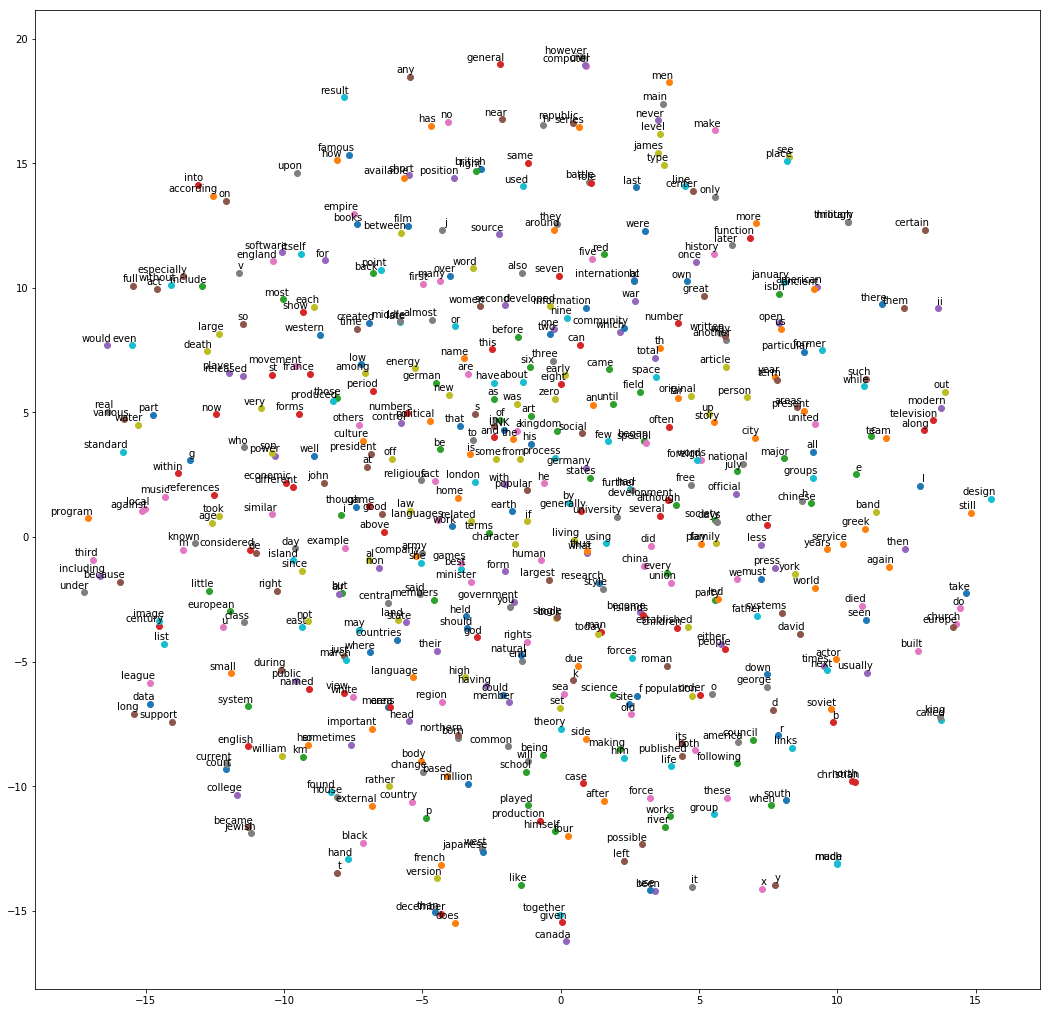

In [10]:
startTraining()